# Quantum Machine Learning Basics

## Using the PyTorch Backend Simulator

The isq simulator uses PyTorch as its backend, making it easy to simulate quantum machine learning tasks.

First, import the necessary packages. To ensure the reproducibility of the experiment, we fix the random seed.

In [1]:
import random

import numpy as np
import torch
import torch.optim as optim

from isqtools import IsqCircuit
from isqtools.backend import TorchBackend
from isqtools.neural_networks import TorchLayer


def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)


setup_seed(222)

## Define param Variables for Automatic Differentiation

For quantum machine learning tasks, we need to define arrays of parameterized variables in the `.isq` file using the syntax param `inputs[];` and param `weights[];`. We recommend defining two such variables. If more parameter arrays are required, you may need to implement the gradient computation logic yourself in the `TorchLayer` or `TorchWrapper`.

Currently, the param variables defined in `isq` support three types of rotation gates: `RX`, `RY`, and `RZ`.

Refer to the `.isq` file below for the specific definition. The file is named `nn_basic.isq`.

```c++
import std;


param inputs[], weights[];
qbit q[4];
int pauli_inx[] = {2, 2, 3, 3}; // this means Z0Z1I2I3

// using arrays for pauli measurement, 
// X:0, Y:1, Z:2, I:3

procedure single_h(qbit q[]) {
    for i in 0:q.length {
        H(q[i]);
    }
}

procedure adjacent_cz(qbit q[]) {
    for i in 0:q.length-1 {
        CZ(q[i], q[i+1]);
    }
}

procedure encode_inputs(qbit q[], int start_idx) {
    for i in 0:q.length {
        Rz(inputs[i+start_idx], q[i]);
    }
}

procedure encode_weights(qbit q[], int start_idx) {
    for i in 0:q.length {
        Ry(weights[i+start_idx], q[i]);
    }
    for i in 0:q.length {
        Rx(weights[i+start_idx+4], q[i]);
    }
}

procedure pauli(int puali_idx[], qbit q[]) {
    for i in 0:q.length {
        if (puali_idx[i] == 0) {
            H(q[i]);
            M(q[i]);
        }
        if (puali_idx[i] == 1) {
            X2P(q[i]);
            M(q[i]);
        }
        if (puali_idx[i] == 2) {
            M(q[i]);
        }
        if (puali_idx[i] == 3) {
            continue;
        }
    }
}

procedure main() {

    single_h(q);
    encode_inputs(q, 0);
    adjacent_cz(q);

    encode_weights(q, 0);
    adjacent_cz(q);

    encode_weights(q, 8);
    adjacent_cz(q);

    encode_weights(q, 16);
    adjacent_cz(q);

    pauli(pauli_inx, q);
}
```

We use `tempfile`to simulate here.

In [2]:
FILE_CONTENT = """\
import std;


param inputs[], weights[];
qbit q[4];
int pauli_inx[] = [2, 2, 3, 3]; // this means Z0Z1I2I3

// using arrays for pauli measurement, 
// X:0, Y:1, Z:2, I:3

procedure single_h(qbit q[]) {
    for i in 0:q.length {
        H(q[i]);
    }
}

procedure adjacent_cz(qbit q[]) {
    for i in 0:q.length-1 {
        CZ(q[i], q[i+1]);
    }
}

procedure encode_inputs(qbit q[], int start_idx) {
    for i in 0:q.length {
        Rz(inputs[i+start_idx], q[i]);
    }
}

procedure encode_weights(qbit q[], int start_idx) {
    for i in 0:q.length {
        Ry(weights[i+start_idx], q[i]);
    }
    for i in 0:q.length {
        Rx(weights[i+start_idx+4], q[i]);
    }
}

procedure pauli(int puali_idx[], qbit q[]) {
    for i in 0:q.length {
        if (puali_idx[i] == 0) {
            H(q[i]);
            M(q[i]);
        }
        if (puali_idx[i] == 1) {
            X2P(q[i]);
            M(q[i]);
        }
        if (puali_idx[i] == 2) {
            M(q[i]);
        }
        if (puali_idx[i] == 3) {
            continue;
        }
    }
}

procedure main() {

    single_h(q);
    encode_inputs(q, 0);
    adjacent_cz(q);

    encode_weights(q, 0);
    adjacent_cz(q);

    encode_weights(q, 8);
    adjacent_cz(q);

    encode_weights(q, 16);
    adjacent_cz(q);

    pauli(pauli_inx, q);
}"""

For quantum machine learning simulation tasks, we highly recommend using PyTorch as the simulation backend. PyTorch supports automatic differentiation, making it easy to compute the gradients of parameterized circuits. It also supports parallelism and GPU acceleration, offering high computational efficiency. Additionally, with `torch.vmap` (available in PyTorch version 2.0 and above), you can efficiently perform batched circuit simulations, which is significantly faster than using a simple for-loop.

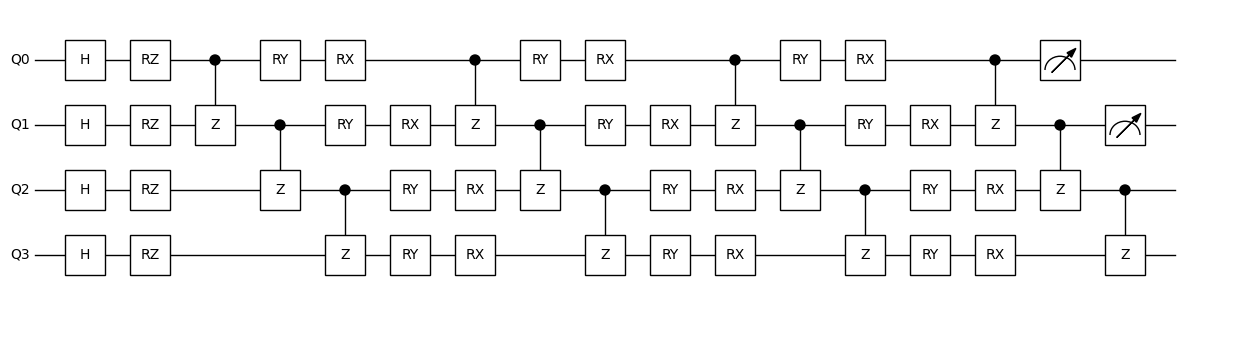

In [3]:
import tempfile
from pathlib import Path

from isqtools.draw import Drawer

backend = TorchBackend()

with tempfile.TemporaryDirectory() as temp_dir:
    temp_dir_path = Path(temp_dir)
    temp_file_path = temp_dir_path / "nn_basic.isq"
    with open(temp_file_path, "w") as temp_file:
        temp_file.write(FILE_CONTENT)
    qc = IsqCircuit(
        file=str(temp_file_path),
        backend=backend,
        sample=False,
    )
    dr = Drawer()
    dr.plot(qc.qcis)

## Create a Quantum Circuit

To build a quantum circuit for quantum machine learning, we first need to define a function. Below is an example using a function named `circuit`.

This function takes two arguments: `inputs` and `weights`. Here, inputs represents the data to be encoded. The circuit simulation and measurement are performed using the `pauli_measure()` method. When using `pauli_measure()`, a basis transformation must be implemented in the `.isq` file. We have provided an example of this in `nn_basic.isq` with the procedure `procedure pauli(int pauli_idx[], qbit q[])`.

Advanced users may define custom measurement procedures if needed. When using parameterized circuits, parameters should be passed in key-value form. The syntax `**param` unpacks a Python dictionary, which is equivalent to passing arguments in key-value pairs. Each key should match the parameter names defined in the `.isq` file (e.g., `param inputs[]`, `param weights[]` in `nn_basic.isq`), and each value corresponds to the input arguments of the Python function `def circuit(inputs, weights)`.

In [4]:
def circuit(inputs, weights):

    param = {
        "inputs": inputs,
        "weights": weights,
    }

    return qc.pauli_measure(**param)

## Forward Measurement Circuit

When using PyTorch as the simulation backend, we define the parameters as `torch.Tensor` objects.

In this example, we randomly generate `inputs` and `weights`, then pass them to the `circuit` function. This will return the result of the Pauli measurement.

In [5]:
inputs = torch.randn(4)
weights = torch.randn(24)
weights_backup = weights.clone()
inputs_backup = inputs.clone()
print(f"{inputs=}")
print(f"{weights=}")
print("Result:", circuit(inputs, weights))

inputs=tensor([-0.4248,  1.1523, -2.1342,  0.5376])
weights=tensor([ 0.3889, -0.7956, -0.4133, -0.2245, -1.3118,  0.4663, -0.9789,  1.3999,
         1.6718,  0.1663, -0.4762, -1.0917,  0.5813, -0.1228, -0.0768, -0.7945,
        -0.8038, -0.1344, -0.9184, -0.3778,  0.4568,  0.7652,  0.4885, -2.1489])
Result: tensor(-0.1275)


## Create a Quantum Machine Learning Layer

By using `TorchLayer` and passing in the previously defined `circuit` function along with some necessary parameters, we can obtain a `qnn` object that inherits from `torch.nn.Module`.

`is_vmap=False` indicates that `vmap` is not used.

`num_weights` specifies the length of the weights parameter.

`initial_weights` allows you to provide a custom initialization for the weights; if not specified, the parameters will be initialized automatically.

We can compare the outputs of `circuit` and `qnn` to observe the difference. Pay attention to how the parameters are passed. Thanks to the use of `torch.nn.Module`, gradient information is automatically constructed for the `qnn` layer.

In [6]:
qnn = TorchLayer(
    circuit=circuit,
    is_vmap=False,
    num_weights=24,
    initial_weights=weights,
)

print(qnn)
print(qnn.__class__.__bases__)
print()
print("Run circuit:", circuit(inputs, weights))
print("Run qnn:", qnn(inputs))

TorchLayer(num_weights=24, is_vmap=False)
(<class 'torch.nn.modules.module.Module'>,)

Run circuit: tensor(-0.1275)
Run qnn: tensor(-0.1275, grad_fn=<DotBackward0>)


## Optimize the Quantum Circuit

Since qnn inherits from `torch.nn.Module`, we can conveniently use PyTorch's optimizers to optimize it.

In this example, we apply SGD (Stochastic Gradient Descent) to update the weights while keeping inputs fixed, aiming to minimize the output of `qnn`, which corresponds to the result of the Pauli measurement.

After 50 optimization steps, the Pauli measurement value converges to its minimum, which is -1.

In [7]:
optimizer = optim.SGD(qnn.parameters(), lr=0.05)

for i in range(50):
    measurement = qnn(inputs)
    measurement.backward()
    optimizer.step()
    optimizer.zero_grad()
    if i % 5 == 0:
        print(measurement)

tensor(-0.1275, grad_fn=<DotBackward0>)
tensor(-0.3230, grad_fn=<DotBackward0>)
tensor(-0.4942, grad_fn=<DotBackward0>)
tensor(-0.6281, grad_fn=<DotBackward0>)
tensor(-0.7245, grad_fn=<DotBackward0>)
tensor(-0.7911, grad_fn=<DotBackward0>)
tensor(-0.8372, grad_fn=<DotBackward0>)
tensor(-0.8697, grad_fn=<DotBackward0>)
tensor(-0.8935, grad_fn=<DotBackward0>)
tensor(-0.9115, grad_fn=<DotBackward0>)


You can print the optimized `inputs` and `weights` after the training process.

As `inputs` serve as the fixed input data, they remain unchanged throughout the optimization. In contrast, `weights` are gradually updated and optimized toward their optimal values, causing the Pauli measurement output to approach -1.

In [8]:
print(f"{inputs}")
print(f"{inputs_backup}")
print("Optimized weights:", weights)
print(f"{weights_backup=}")

tensor([-0.4248,  1.1523, -2.1342,  0.5376])
tensor([-0.4248,  1.1523, -2.1342,  0.5376])
Optimized weights: tensor([ 0.3963, -0.4383, -0.5218, -0.2149, -1.5535,  1.0736, -0.9547,  1.4377,
         2.3391, -0.0104, -0.1606, -1.0917,  0.4081, -0.2264, -0.2291, -0.7945,
        -1.0293, -0.6749, -0.9184, -0.3778,  0.4045,  0.9554,  0.4885, -2.1489])
weights_backup=tensor([ 0.3889, -0.7956, -0.4133, -0.2245, -1.3118,  0.4663, -0.9789,  1.3999,
         1.6718,  0.1663, -0.4762, -1.0917,  0.5813, -0.1228, -0.0768, -0.7945,
        -0.8038, -0.1344, -0.9184, -0.3778,  0.4568,  0.7652,  0.4885, -2.1489])


## Environment Information

The following versions of software and libraries are used in this tutorial:

In [9]:
import platform
import subprocess
from importlib.metadata import version

print(f"Python version used in this tutorial: {platform.python_version()}")
print(f"Execution environment: {platform.system()} {platform.release()}\n")


isqc_version = subprocess.check_output(
    ["isqc", "-V"], stderr=subprocess.STDOUT, text=True
).strip()
print(f"isqc version: {isqc_version}")

isqtools_version = version("isqtools")
print(f"isqtools version: {isqtools_version}")

numpy_version = version("numpy")
print(f"NumPy version: {isqtools_version}")

torch_version = version("torch")
print(f"Torch version: {torch_version}")

Python version used in this tutorial: 3.13.5
Execution environment: Linux 6.12.41

isqc version: isQ Compiler 0.2.5
isqtools version: 1.3.0
NumPy version: 1.3.0
Torch version: 2.7.1
